Trabalho 2 — PGA para Coloração de Grafos (GCP)

Implementação em **Python** do algoritmo do artigo base “Parallel Genetic Algorithm for Graph Coloring Problem”
com:
- Operadores: SPPX, CEX, GPX, UISX
- Mutação: First Fit e Transposition
- Modelo de migração (ilhas)
- Experimentos: repetição, estatísticas e tabelas (sem boxplots)

Requisitos e artigo base (arquivos fornecidos):
- Descrição do trabalho :contentReference[oaicite:1]{index=1}
- Artigo base :contentReference[oaicite:2]{index=2}

0) Setup

In [1]:
import sys
print(sys.executable)

c:\Users\marce\OneDrive - Universidade Federal de Uberlândia\Área de Trabalho\IC\aplicacao-algoritmosGeneticos-inteligenciaComp_2025-2\aplicacao-algoritmosGeneticos-inteligenciaComp_2025-2\.venv\Scripts\python.exe


In [2]:
import os, time, math, random, itertools
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


GLOBAL_SEED = 42
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("OK - Setup carregado")

OK - Setup carregado


 1) Grafo + Parser DIMACS

Coloque instâncias DIMACS em `./instances/` e ajuste os nomes em `BENCH_FILES`.

In [3]:
@dataclass
class Graph:
    n: int
    edges_u: np.ndarray
    edges_v: np.ndarray
    adj: List[np.ndarray]
    neighbors_set: List[set]

    @property
    def m(self) -> int:
        return int(self.edges_u.shape[0])

def read_dimacs_col(path: str) -> Graph:
    n = None
    edges = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("c"):
                continue
            parts = line.split()
            if parts[0] == "p":
                n = int(parts[2])
            elif parts[0] == "e":
                u = int(parts[1]) - 1
                v = int(parts[2]) - 1
                if u != v:
                    edges.append((min(u, v), max(u, v)))

    if n is None:
        raise ValueError("Arquivo sem linha 'p edge n m'")

    edges = sorted(set(edges))
    edges_u = np.array([u for u, _ in edges], dtype=np.int32)
    edges_v = np.array([v for _, v in edges], dtype=np.int32)

    adj_list = [[] for _ in range(n)]
    for u, v in edges:
        adj_list[u].append(v)
        adj_list[v].append(u)

    adj = [np.array(nei, dtype=np.int32) for nei in adj_list]
    neighbors_set = [set(nei) for nei in adj_list]
    return Graph(n=n, edges_u=edges_u, edges_v=edges_v, adj=adj, neighbors_set=neighbors_set)

def make_cycle_graph(n: int) -> Graph:
    edges = [(i, (i + 1) % n) for i in range(n)]
    edges_u = np.array([u for u, _ in edges], dtype=np.int32)
    edges_v = np.array([v for _, v in edges], dtype=np.int32)
    adj_list = [[] for _ in range(n)]
    for u, v in edges:
        adj_list[u].append(v)
        adj_list[v].append(u)
    adj = [np.array(nei, dtype=np.int32) for nei in adj_list]
    neighbors_set = [set(nei) for nei in adj_list]
    return Graph(n=n, edges_u=edges_u, edges_v=edges_v, adj=adj, neighbors_set=neighbors_set)

print("OK - Parser DIMACS pronto")

OK - Parser DIMACS pronto


 2) Representação + função de custo do artigo

Custo do artigo:  f(p) = Σ q(u,v) + d + C
- q(u,v)=2 se conflito (mesma cor), senão 0
- d=1 se existe qualquer conflito, senão 0
- C = número de cores usadas
Fitness = 1/f(p)

In [4]:
def relabel_colors(colors: np.ndarray) -> np.ndarray:
    mapping = {}
    out = np.empty_like(colors)
    for i, c in enumerate(colors.tolist()):
        if c not in mapping:
            mapping[c] = len(mapping)
        out[i] = mapping[c]
    return out

def assignment_to_partition(colors: np.ndarray) -> List[set]:
    buckets: Dict[int, set] = {}
    for v, c in enumerate(colors.tolist()):
        buckets.setdefault(int(c), set()).add(v)
    return [buckets[k] for k in sorted(buckets.keys())]

def partition_to_assignment(part: List[set], n: int) -> np.ndarray:
    colors = np.full(n, -1, dtype=np.int32)
    for cid, block in enumerate(part):
        for v in block:
            colors[v] = cid
    if np.any(colors < 0):
        raise ValueError("Partição não cobre todos os vértices.")
    return colors

def count_conflicts(colors: np.ndarray, g: Graph) -> int:
    return int(np.sum(colors[g.edges_u] == colors[g.edges_v]))

def cost_article(colors: np.ndarray, g: Graph) -> Tuple[int, int, int]:
    conflicts = count_conflicts(colors, g)
    d = 1 if conflicts > 0 else 0
    C = int(len(np.unique(colors)))
    f = 2 * conflicts + d + C
    return f, conflicts, C

@dataclass
class Individual:
    colors: np.ndarray
    f: int
    conflicts: int
    C: int
    fitness: float

def eval_ind(colors: np.ndarray, g: Graph) -> Individual:
    colors = relabel_colors(colors.astype(np.int32))
    f, conf, C = cost_article(colors, g)
    return Individual(colors=colors, f=f, conflicts=conf, C=C, fitness=1.0 / float(f))

print("OK - avaliação pronta")

OK - avaliação pronta


 3) Inicialização + Seleção + Mutação

- Inicialização: greedy First-Fit com ordem aleatória (gera coloração factível).
- Seleção: roleta (proporcional ao fitness).
- Mutação:
  - Transposition: troca cores de 2 vértices
  - First Fit: tenta mover vértices de uma cor para outras cores sem conflito (pode reduzir #cores)

In [5]:
def greedy_first_fit(g: Graph, rng: random.Random) -> np.ndarray:
    order = list(range(g.n))
    rng.shuffle(order)
    colors = np.full(g.n, -1, dtype=np.int32)
    for v in order:
        used = set(colors[u] for u in g.adj[v] if colors[u] >= 0)
        c = 0
        while c in used:
            c += 1
        colors[v] = c
    return relabel_colors(colors)

def random_exact_k_coloring(n: int, k: int, rng: random.Random) -> np.ndarray:
    """
    Gera uma atribuição com EXATAMENTE k cores usadas (todas aparecem ao menos 1 vez).
    Normalmente terá conflitos (como no cenário do artigo quando k ótimo é conhecido).
    """
    if k <= 0:
        raise ValueError("k deve ser >= 1")
    if k > n:
        k = n

    # garante que todas as cores 0..k-1 apareçam
    arr = list(range(k))
    # completa os demais vértices com cores aleatórias em [0,k)
    arr += [rng.randrange(k) for _ in range(n - k)]
    rng.shuffle(arr)
    return np.array(arr, dtype=np.int32)

def init_population(
    g: Graph,
    pop_size: int,
    rng: random.Random,
    init_mode: str = "greedy",          # "greedy" | "random_k"
    k_fixed: Optional[int] = None
) -> List[Individual]:
    pop = []
    for _ in range(pop_size):
        if init_mode == "greedy":
            colors = greedy_first_fit(g, rng)
        elif init_mode == "random_k":
            if k_fixed is None:
                raise ValueError("init_mode='random_k' exige k_fixed")
            colors = random_exact_k_coloring(g.n, k_fixed, rng)
        else:
            raise ValueError("init_mode inválido: use 'greedy' ou 'random_k'")
        pop.append(eval_ind(colors, g))
    return pop

def roulette_select(pop: List[Individual], k: int, rng: random.Random) -> List[Individual]:
    return rng.choices(pop, weights=[p.fitness for p in pop], k=k)

def mutate_transposition(colors: np.ndarray, rng: random.Random) -> np.ndarray:
    n = len(colors)
    if n < 2:
        return colors.copy()
    i = rng.randrange(n)
    j = rng.randrange(n)
    while j == i:
        j = rng.randrange(n)
    out = colors.copy()
    out[i], out[j] = out[j], out[i]
    return relabel_colors(out)

def mutate_first_fit(colors: np.ndarray, g: Graph, rng: random.Random) -> np.ndarray:
    part = assignment_to_partition(colors)
    if len(part) <= 1:
        return colors.copy()
    idx = rng.randrange(len(part))
    verts = list(part[idx])
    rng.shuffle(verts)

    for v in verts:
        for j, target in enumerate(part):
            if j == idx:
                continue
            if len(g.neighbors_set[v].intersection(target)) == 0:
                part[idx].remove(v)
                target.add(v)
                break

    part = [b for b in part if len(b) > 0]
    return relabel_colors(partition_to_assignment(part, g.n))

print("OK - init/sel/mut (com random_k) pronto")


OK - init/sel/mut (com random_k) pronto


4) Crossovers (SPPX / CEX / GPX / UISX)

Implementações baseadas na descrição/pseudocódigos do artigo :contentReference[oaicite:4]{index=4}

 **SPPX** (Figura 1):
 - PRODUCT: usa interseção de um bloco de p com um bloco de r e “separa” o restante por diferença.
 - SUM: faz união de um bloco de p com um bloco de r e remove sobreposições via diferenças.

 Nota prática (importante):
 - No PRODUCT, para manter cobertura total e bater com o Example1 do artigo, incluímos também o “resto” do bloco selecionado.

In [6]:
def _copy_part(p: List[set]) -> List[set]:
    return [set(b) for b in p]

# --- SPPX ---
def sppx_product(p: List[set], r: List[set], rng: random.Random) -> Tuple[List[set], List[set]]:
    if not p or not r:
        return _copy_part(p), _copy_part(r)
    h = rng.randrange(len(p))
    j = rng.randrange(len(r))
    inter = set(p[h].intersection(r[j]))
    if len(inter) == 0:
        return _copy_part(p), _copy_part(r)

    s = [inter]
    t = [set(inter)]
    for b in p:
        d = set(b.difference(inter))
        if d:
            s.append(d)
    for b in r:
        d = set(b.difference(inter))
        if d:
            t.append(d)
    return s, t

def sppx_sum(p: List[set], r: List[set], rng: random.Random) -> Tuple[List[set], List[set]]:
    if not p or not r:
        return _copy_part(p), _copy_part(r)
    h = rng.randrange(len(p))
    j = rng.randrange(len(r))
    union = set(p[h].union(r[j]))
    s = [union]
    t = [set(union)]
    for i, b in enumerate(p):
        if i == h:
            continue
        d = set(b.difference(r[j]))
        if d:
            s.append(d)
    for i, b in enumerate(r):
        if i == j:
            continue
        d = set(b.difference(p[h]))
        if d:
            t.append(d)
    return s, t

def sppx(p1, p2, r1, r2, prob_product: float, prob_sum: float, rng: random.Random) -> List[List[set]]:
    if rng.random() <= prob_product:
        s1, t1 = sppx_product(p1, r1, rng)
    else:
        s1, t1 = _copy_part(p1), _copy_part(r1)
    if rng.random() <= prob_sum:
        s2, t2 = sppx_sum(p2, r2, rng)
    else:
        s2, t2 = _copy_part(p2), _copy_part(r2)
    return [s1, t1, s2, t2]

# --- CEX ---
def conflict_free_vertices(colors: np.ndarray, g: Graph) -> np.ndarray:
    cf = np.ones(g.n, dtype=bool)
    for v in range(g.n):
        c = colors[v]
        for u in g.adj[v]:
            if colors[u] == c:
                cf[v] = False
                break
    return cf

def cex(p: np.ndarray, r: np.ndarray, g: Graph) -> Tuple[np.ndarray, np.ndarray]:
    s = r.copy()
    t = p.copy()
    p_cf = conflict_free_vertices(p, g)
    r_cf = conflict_free_vertices(r, g)
    s[p_cf] = p[p_cf]
    t[r_cf] = r[r_cf]
    return relabel_colors(s), relabel_colors(t)

# --- GPX (Figura 3 - corrigido) ---
def gpx(p0: List[set], p1: List[set], n_vertices: int, rng: random.Random) -> List[set]:
    P0 = _copy_part(p0)
    P1 = _copy_part(p1)
    s = []
    assigned = set()
    k = max(len(P0), len(P1))
    i = 1
    while i <= k:
        parent = P1 if (i % 2 == 1) else P0
        nonempty = [b for b in parent if b]
        if not nonempty:
            break
        V = set(max(nonempty, key=len))
        s.append(V)
        assigned |= V
        P0 = [b.difference(V) for b in P0]
        P1 = [b.difference(V) for b in P1]
        if all(not b for b in P0) and all(not b for b in P1):
            break
        i += 1
    unassigned = list(set(range(n_vertices)).difference(assigned))
    if not s:
        return [set(range(n_vertices))]
    for v in unassigned:
        rng.choice(s).add(v)
    return [b for b in s if b]

# --- UISX (Seção 3.3 - implementação direta) ---
def is_independent_set(block: set, g: Graph) -> bool:
    for v in block:
        if g.neighbors_set[v].intersection(block):
            return False
    return True

def extract_greedy_independent_subset(vertices: List[int], g: Graph, rng: random.Random) -> set:
    verts = vertices[:]
    rng.shuffle(verts)
    S = set()
    for v in verts:
        if not g.neighbors_set[v].intersection(S):
            S.add(v)
    return S

def independent_sets_from_colors(colors: np.ndarray, g: Graph, rng: random.Random) -> List[set]:
    part = assignment_to_partition(colors)
    out = []
    for block in part:
        if not block:
            continue
        if is_independent_set(block, g):
            out.append(set(block))
        else:
            sub = extract_greedy_independent_subset(list(block), g, rng)
            if sub:
                out.append(sub)
    return out

def uisx_one_direction(p_colors: np.ndarray, r_colors: np.ndarray, g: Graph, rng: random.Random) -> np.ndarray:
    n = g.n
    p_IS = independent_sets_from_colors(p_colors, g, rng)
    r_IS = independent_sets_from_colors(r_colors, g, rng)
    blocks = []
    colored = set()
    while p_IS and r_IS:
        A = max(p_IS, key=len)
        inter_sizes = [len(A.intersection(B)) for B in r_IS]
        mx = max(inter_sizes)
        candidates = [i for i, v in enumerate(inter_sizes) if v == mx]
        B = r_IS[rng.choice(candidates)]
        U = set(A.union(B))
        if not U:
            break
        blocks.append(U)
        colored |= U
        p_IS = [S.difference(U) for S in p_IS if S.difference(U)]
        r_IS = [S.difference(U) for S in r_IS if S.difference(U)]
    uncolored = set(range(n)).difference(colored)
    if uncolored:
        buckets: Dict[int, set] = {}
        for v in uncolored:
            buckets.setdefault(int(p_colors[v]), set()).add(v)
        for _, b in sorted(buckets.items(), key=lambda x: x[0]):
            blocks.append(b)
    return relabel_colors(partition_to_assignment(blocks, n))

def uisx(p: np.ndarray, r: np.ndarray, g: Graph, rng: random.Random) -> Tuple[np.ndarray, np.ndarray]:
    return uisx_one_direction(p, r, g, rng), uisx_one_direction(r, p, g, rng)

print("OK - crossovers prontos")

OK - crossovers prontos


5) PGA (ilhas + migração) + Experimentos

Modelo de migração “pure island” descrito no artigo
 - a cada `migration_interval` gerações, cada ilha envia `migration_size` indivíduos para todas as outras
 - imigrantes substituem indivíduos aleatórios no host
 - emigrantes ficam na origem (cópias)

Critério de parada:
 - se `target_colors` (ótimo) é conhecido: parar ao encontrar coloração factível com C==target
 - senão: roda até `max_generations`

In [7]:
# %% [markdown]
# ## 5) PGA (ilhas + migração) + Experimentos — CORRIGIDO
#
# Correções importantes:
# - Quando target_colors (k) é conhecido (experimento Tabela 1), forçamos manter exatamente k cores.
#   Isso evita o caso em que o algoritmo "cai" para C < k e nunca mais consegue atingir C==k.
# - Inicialização para o caso de k conhecido:
#   usamos uma coloração greedy (factível) e então "compactamos" para k cores com reassignment,
#   preservando exatamente k cores presentes (via ensure_k_colors).

from dataclasses import dataclass
from typing import List, Dict, Optional, Any, Tuple
import numpy as np
import pandas as pd
import random, time

@dataclass
class PGAParams:
    pop_size: int = 60
    islands: int = 3
    max_generations: int = 500
    migration_interval: int = 5
    migration_size: int = 5
    migration_scheme: str = "best"   # "best" | "random"
    crossover: str = "CEX"           # "SPPX" | "CEX" | "GPX" | "UISX"
    mutation: str = "first_fit"      # "first_fit" | "transposition"
    mutation_prob: float = 0.1
    prob_product: float = 0.5        # SPPX
    prob_sum: float = 0.7            # SPPX
    elitism: int = 0                 # recomendado 0 no experimento do artigo
    fixed_k: Optional[int] = None    # <-- quando setado, força manter exatamente k cores

def ensure_k_colors(colors: np.ndarray, k: int, rng: random.Random) -> np.ndarray:
    """
    Garante que TODAS as cores 0..k-1 apareçam ao menos 1 vez.
    Se alguma cor estiver faltando, move um vértice de uma cor doadora (com >1 vértice) para a cor faltante.
    """
    out = colors.copy().astype(np.int32)
    n = out.size
    if k is None:
        return out
    if k <= 0:
        return out
    if k > n:
        k = n

    # força range 0..k-1 (se tiver lixo fora)
    out = np.mod(out, k).astype(np.int32)

    counts = np.bincount(out, minlength=k)
    missing = [c for c in range(k) if counts[c] == 0]
    if not missing:
        return out

    for c in missing:
        donors = np.where(counts > 1)[0]
        if donors.size == 0:
            break
        donor = int(rng.choice(donors))
        idxs = np.where(out == donor)[0]
        v = int(rng.choice(idxs))
        out[v] = c
        counts[donor] -= 1
        counts[c] += 1

    return out

def apply_mutation(colors: np.ndarray, g: Graph, p: PGAParams, rng: random.Random) -> np.ndarray:
    if rng.random() > p.mutation_prob:
        out = colors
    else:
        if p.mutation == "first_fit":
            out = mutate_first_fit(colors, g, rng)
        else:
            out = mutate_transposition(colors, rng)

    # Se estamos no experimento "k conhecido", mantém exatamente k cores
    if p.fixed_k is not None:
        out = ensure_k_colors(out, p.fixed_k, rng)

    return out

def best_of(pop: List[Individual]) -> Individual:
    return min(pop, key=lambda ind: ind.f)

def init_individual_fixed_k(g: Graph, k: int, rng: random.Random) -> np.ndarray:
    """
    Inicialização mais estável para k conhecido:
    - gera coloração factível via greedy (pode ter C>=k normalmente)
    - compacta para k cores: mantém as k primeiras classes e redistribui o resto aleatoriamente
    - garante que todas as k cores aparecem (ensure_k_colors)
    """
    base = greedy_first_fit(g, rng)  # factível
    part = assignment_to_partition(base)

    # Se greedy deu menos cores que k (raro se k é número cromático), "força" k via ensure_k_colors depois
    # Se greedy deu mais que k (comum), compacta
    if len(part) > k:
        kept = [set(part[i]) for i in range(k)]
        leftover = []
        for i in range(k, len(part)):
            leftover.extend(list(part[i]))
        rng.shuffle(leftover)
        for v in leftover:
            rng.choice(kept).add(v)
        colors = partition_to_assignment(kept, g.n)
    else:
        colors = partition_to_assignment(part, g.n)

    colors = ensure_k_colors(colors, k, rng)

    # Pequena "bagunça" opcional (evita resolver em GEN0 em grafos pequenos):
    # troca ~1% dos vértices pra cores aleatórias (mantém k)
    if g.n >= 50:
        swaps = max(1, g.n // 100)
        for _ in range(swaps):
            v = rng.randrange(g.n)
            colors[v] = rng.randrange(k)
        colors = ensure_k_colors(colors, k, rng)

    return relabel_colors(colors)

def init_population_pga(g: Graph, p: PGAParams, rng: random.Random) -> List[Individual]:
    if p.fixed_k is None:
        # modo original: greedy first fit (factível, C varia)
        return [eval_ind(greedy_first_fit(g, rng), g) for _ in range(p.pop_size)]
    else:
        # modo k conhecido: inicia com exatamente k cores (pode ter conflitos)
        return [eval_ind(init_individual_fixed_k(g, p.fixed_k, rng), g) for _ in range(p.pop_size)]

def reproduce_gpx_article(pop: List[Individual], g: Graph, p: PGAParams, rng: random.Random) -> List[Individual]:
    """
    GPX no estilo do artigo:
    - produz 1 offspring por operação
    - substitui apenas o primeiro pai (pai1)
    - o segundo pai (pai2) permanece na população e pode recombinar novamente na mesma geração
    """
    cur = [
        Individual(colors=ind.colors.copy(), f=ind.f, conflicts=ind.conflicts, C=ind.C, fitness=ind.fitness)
        for ind in pop
    ]

    protected = set()
    if p.elitism > 0:
        elite_idx = np.argsort([ind.f for ind in cur])[:p.elitism]
        protected = set(elite_idx.tolist())

    def pick_index(weights: List[float], forbid: set) -> int:
        while True:
            idx = rng.choices(range(len(cur)), weights=weights, k=1)[0]
            if idx not in forbid:
                return idx

    steps = p.pop_size - p.elitism
    steps = max(0, steps)

    for _ in range(steps):
        weights = [ind.fitness for ind in cur]

        i1 = pick_index(weights, protected)
        i2 = rng.choices(range(len(cur)), weights=weights, k=1)[0]
        while i2 == i1:
            i2 = rng.choices(range(len(cur)), weights=weights, k=1)[0]

        pa = assignment_to_partition(cur[i1].colors)
        pb = assignment_to_partition(cur[i2].colors)

        child_part = gpx(pa, pb, g.n, rng)
        child_colors = partition_to_assignment(child_part, g.n)

        child_colors = apply_mutation(child_colors, g, p, rng)
        cur[i1] = eval_ind(child_colors, g)

    return cur

def reproduce(pop: List[Individual], g: Graph, p: PGAParams, rng: random.Random) -> List[Individual]:
    if p.crossover == "GPX":
        return reproduce_gpx_article(pop, g, p, rng)

    new_pop = []

    if p.elitism > 0:
        elites = sorted(pop, key=lambda ind: ind.f)[:p.elitism]
        for e in elites:
            new_pop.append(Individual(colors=e.colors.copy(), f=e.f, conflicts=e.conflicts, C=e.C, fitness=e.fitness))

    while len(new_pop) < p.pop_size:
        if p.crossover == "SPPX":
            parents = roulette_select(pop, 4, rng)
            p1, p2, r1, r2 = [assignment_to_partition(x.colors) for x in parents]
            kids = sppx(p1, p2, r1, r2, p.prob_product, p.prob_sum, rng)

            for part in kids:
                if len(new_pop) >= p.pop_size:
                    break
                c = partition_to_assignment(part, g.n)
                c = apply_mutation(c, g, p, rng)
                new_pop.append(eval_ind(c, g))

        elif p.crossover == "CEX":
            a, b = roulette_select(pop, 2, rng)
            c1, c2 = cex(a.colors, b.colors, g)
            c1 = apply_mutation(c1, g, p, rng)
            c2 = apply_mutation(c2, g, p, rng)
            new_pop.append(eval_ind(c1, g))
            if len(new_pop) < p.pop_size:
                new_pop.append(eval_ind(c2, g))

        elif p.crossover == "UISX":
            a, b = roulette_select(pop, 2, rng)
            c1, c2 = uisx(a.colors, b.colors, g, rng)
            c1 = apply_mutation(c1, g, p, rng)
            c2 = apply_mutation(c2, g, p, rng)
            new_pop.append(eval_ind(c1, g))
            if len(new_pop) < p.pop_size:
                new_pop.append(eval_ind(c2, g))
        else:
            raise ValueError("crossover inválido")

    return new_pop[:p.pop_size]

def migrate(islands_pops: List[List[Individual]], p: PGAParams, rng: random.Random) -> None:
    I = p.islands
    if I <= 1 or p.migration_size <= 0:
        return

    emigrants = []
    for pop in islands_pops:
        if p.migration_scheme == "best":
            em = sorted(pop, key=lambda ind: ind.f)[:p.migration_size]
        else:
            em = rng.sample(pop, k=min(p.migration_size, len(pop)))
        emigrants.append([
            Individual(colors=e.colors.copy(), f=e.f, conflicts=e.conflicts, C=e.C, fitness=e.fitness)
            for e in em
        ])

    for src in range(I):
        for dst in range(I):
            if src == dst:
                continue
            host = islands_pops[dst]
            for imm in emigrants[src]:
                pos = rng.randrange(len(host))
                host[pos] = Individual(colors=imm.colors.copy(), f=imm.f, conflicts=imm.conflicts, C=imm.C, fitness=imm.fitness)

def run_pga(g: Graph, p: PGAParams, target_colors: Optional[int], seed: int, verbose: bool = False) -> Dict[str, Any]:
    # IMPORTANTÍSSIMO: quando o alvo k é conhecido, ativa fixed_k
    p = PGAParams(**{**p.__dict__, "fixed_k": target_colors if target_colors is not None else None})

    islands = [init_population_pga(g, p, random.Random(seed + 1000 * i + 7)) for i in range(p.islands)]

    hist = []
    start = time.perf_counter()
    solved_gen = None

    for gen in range(1, p.max_generations + 1):
        for i in range(p.islands):
            islands[i] = reproduce(islands[i], g, p, random.Random(seed + 999 * i + gen))

        if p.migration_interval > 0 and gen % p.migration_interval == 0:
            migrate(islands, p, random.Random(seed + 12345 + gen))

        bg = min([best_of(pop) for pop in islands], key=lambda ind: ind.f)
        hist.append((gen, bg.f, bg.conflicts, bg.C))

        if verbose and gen % 20 == 0:
            print(gen, bg.f, bg.conflicts, bg.C)

        if target_colors is not None and bg.conflicts == 0 and bg.C == target_colors:
            solved_gen = gen
            break

    elapsed = time.perf_counter() - start
    return {
        "solved_gen": solved_gen,
        "elapsed_s": elapsed,
        "best_C": bg.C,
        "best_conflicts": bg.conflicts,
        "history": pd.DataFrame(hist, columns=["gen", "best_f", "best_conflicts", "best_C"]),
    }

def run_repeated(g: Graph, p: PGAParams, target_colors: Optional[int], runs: int, base_seed: int = 0) -> pd.DataFrame:
    rows = []
    for r in range(runs):
        out = run_pga(g, p, target_colors, seed=base_seed + r * 10000 + 7)
        rows.append({
            "run": r,
            "solved_gen": out["solved_gen"],
            "elapsed_s": out["elapsed_s"],
            "best_C": out["best_C"],
            "best_conflicts": out["best_conflicts"],
            "crossover": p.crossover,
            "mutation_prob": p.mutation_prob,
            "migration_interval": p.migration_interval,
            "migration_size": p.migration_size,
            "islands": p.islands,
            "pop_size": p.pop_size,
        })
    return pd.DataFrame(rows)

def summarize_runs(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["success"] = df["solved_gen"].notna()
    group_cols = [c for c in df.columns if c not in ["run", "solved_gen", "elapsed_s", "best_C", "best_conflicts", "success"]]

    base = df.groupby(group_cols).agg(
        runs=("run", "count"),
        success_rate=("success", "mean"),
        elapsed_mean=("elapsed_s", "mean"),
        elapsed_std=("elapsed_s", "std"),
    ).reset_index()

    solved = df[df["success"]].groupby(group_cols)["solved_gen"].agg(["mean", "std", "median", "min", "max"]).reset_index()
    solved = solved.rename(columns={
        "mean": "solved_gen_mean",
        "std": "solved_gen_std",
        "median": "solved_gen_median",
        "min": "solved_gen_min",
        "max": "solved_gen_max"
    })

    out = base.merge(solved, on=group_cols, how="left")
    out["success_rate"] = out["success_rate"] * 100.0
    return out.sort_values(["success_rate", "solved_gen_mean", "elapsed_mean"], ascending=[False, True, True])

def make_table1_like(df_main: pd.DataFrame,
                     bench_graphs: Dict[str, Graph],
                     target_colors: Dict[str, int],
                     crossovers=("GPX", "SPPX", "CEX")) -> pd.DataFrame:
    """
    Tabela no formato da Tabela 1 do artigo:
    - n = média de solved_gen apenas em execuções com sucesso
    - t = média de elapsed_s apenas em execuções com sucesso
    - n arredondado para inteiro; t com 1 casa decimal
    """
    rows = []
    for gname, g in bench_graphs.items():
        row = {
            "graph": gname,
            "vertices": g.n,
            "edges": g.m,
            "colors": target_colors.get(gname, np.nan),
        }

        sub_g = df_main[df_main["graph"] == gname]
        for cx in crossovers:
            sub = sub_g[sub_g["crossover"] == cx]
            succ = sub[sub["solved_gen"].notna()]
            if len(succ) == 0:
                row[f"{cx}_n"] = np.nan
                row[f"{cx}_t"] = np.nan
            else:
                row[f"{cx}_n"] = int(round(float(succ["solved_gen"].mean())))
                row[f"{cx}_t"] = round(float(succ["elapsed_s"].mean()), 1)

        rows.append(row)

    cols = ["graph", "vertices", "edges", "colors"] + [f"{cx}_{s}" for cx in crossovers for s in ("n", "t")]
    return pd.DataFrame(rows)[cols].sort_values("graph").reset_index(drop=True)

print("OK - PGA/experimentos (corrigido) pronto")


OK - PGA/experimentos (corrigido) pronto


5.1 Validação rápida com grafo pequeno

Ciclo de 10 vértices tem número cromático 2.

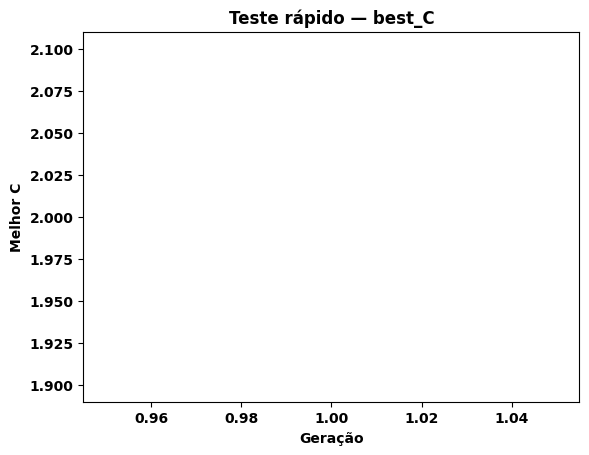

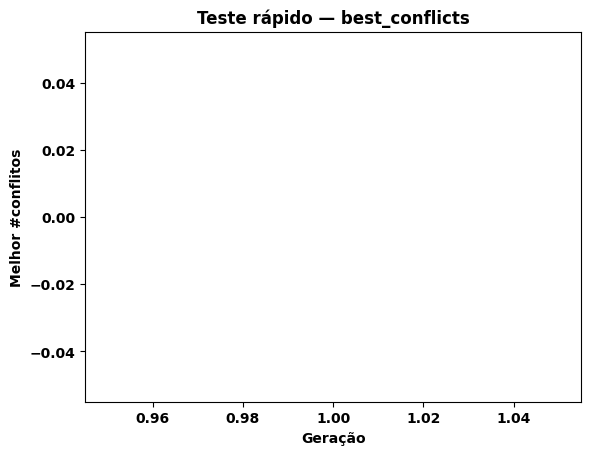

In [8]:
g_test = make_cycle_graph(10)
p_quick = PGAParams(pop_size=40, islands=3, max_generations=200, migration_interval=5, migration_size=3,
                    crossover="CEX", mutation="first_fit", mutation_prob=0.1, elitism=0)

out = run_pga(g_test, p_quick, target_colors=2, seed=123, verbose=False)
out["solved_gen"], out["elapsed_s"], out["best_conflicts"], out["best_C"]

# %%
# (Mantido) gráficos rápidos de validação do run (não são boxplots)
hist = out["history"]
plt.figure()
plt.plot(hist["gen"], hist["best_C"])
plt.xlabel("Geração"); plt.ylabel("Melhor C"); plt.title("Teste rápido — best_C")
plt.show()

plt.figure()
plt.plot(hist["gen"], hist["best_conflicts"])
plt.xlabel("Geração"); plt.ylabel("Melhor #conflitos"); plt.title("Teste rápido — best_conflicts")
plt.show()

6) Reprodução do experimento principal do artigo (Tabela 1)

O artigo usa as instâncias: anna, david, huck, miles500, myciel7, mulsol1 e reporta o ótimo (cores) para cada uma.


In [9]:
# %% [markdown]
# ## 6) Reprodução do experimento principal do artigo (Tabela 1) — sem gráficos

ARTICLE_TARGET_COLORS = {
    "anna": 11, "david": 11, "huck": 11, "miles500": 20, "myciel7": 8, "mulsol1": 49
}

INST_DIR = "./instances"
BENCH_FILES = {name: os.path.join(INST_DIR, f"{name}.col") for name in ARTICLE_TARGET_COLORS.keys()}

def load_benchmarks(files: Dict[str, str]) -> Dict[str, Graph]:
    out = {}
    for name, path in files.items():
        if os.path.exists(path):
            out[name] = read_dimacs_col(path)
            print(f"Loaded {name}: n={out[name].n} m={out[name].m}")
        else:
            print(f"[AVISO] faltando: {path}")
    return out

bench_graphs = load_benchmarks(BENCH_FILES)
print("Grafos carregados:", list(bench_graphs.keys()))

RUNS = 3
MAX_GEN = 500

base = PGAParams(
    pop_size=60,
    islands=3,                 # o artigo usa 3 na Tabela 1
    max_generations=MAX_GEN,
    migration_interval=5,
    migration_size=5,
    migration_scheme="best",
    mutation="first_fit",
    mutation_prob=0.1,
    elitism=0
)

CROSSOVERS = ["GPX", "SPPX", "CEX"]

rows = []
for gname, g in bench_graphs.items():
    target = ARTICLE_TARGET_COLORS[gname]
    for cx in CROSSOVERS:
        p = PGAParams(**{**base.__dict__, "crossover": cx})
        df = run_repeated(g, p, target, runs=RUNS, base_seed=1000)
        df["graph"] = gname
        df["target_colors"] = target
        rows.append(df)

df_main = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

# mostra amostra
print("\nAmostra df_main:")
display(df_main.head(10))

if len(df_main) > 0:
    summary = summarize_runs(df_main)
    print("\nResumo:")
    display(summary[["graph", "crossover", "runs", "success_rate",
                     "solved_gen_mean", "solved_gen_std",
                     "elapsed_mean", "elapsed_std"]])

    print("\n=== Tabela 1 (formato do artigo) — nossos resultados ===")
    table1_ours = make_table1_like(df_main, bench_graphs, ARTICLE_TARGET_COLORS, crossovers=tuple(CROSSOVERS))
    display(table1_ours)
    print(table1_ours.to_string(index=False))
else:
    print("Sem dados (faltam instâncias em ./instances/).")


Loaded anna: n=138 m=493
Loaded david: n=87 m=406
Loaded huck: n=74 m=301
Loaded miles500: n=128 m=1170
Loaded myciel7: n=191 m=2360
Loaded mulsol1: n=197 m=3925
Grafos carregados: ['anna', 'david', 'huck', 'miles500', 'myciel7', 'mulsol1']

Amostra df_main:


,run,solved_gen,elapsed_s,best_C,best_conflicts,crossover,mutation_prob,migration_interval,migration_size,islands,pop_size,graph,target_colors
0,0,1,0.129178,11,0,GPX,0.1,5,5,3,60,anna,11
1,1,1,0.119626,11,0,GPX,0.1,5,5,3,60,anna,11
2,2,1,0.125757,11,0,GPX,0.1,5,5,3,60,anna,11
3,0,1,0.063171,11,0,SPPX,0.1,5,5,3,60,anna,11
4,1,1,0.068115,11,0,SPPX,0.1,5,5,3,60,anna,11
5,2,1,0.060433,11,0,SPPX,0.1,5,5,3,60,anna,11
6,0,1,0.154535,11,0,CEX,0.1,5,5,3,60,anna,11
7,1,1,0.153575,11,0,CEX,0.1,5,5,3,60,anna,11
8,2,1,0.151530,11,0,CEX,0.1,5,5,3,60,anna,11
9,0,1,0.101034,11,0,GPX,0.1,5,5,3,60,david,11



Resumo:


,graph,crossover,runs,success_rate,solved_gen_mean,solved_gen_std,elapsed_mean,elapsed_std
14,huck,SPPX,3,100.000000,1.0,0.000000,0.045855,0.003594
13,david,SPPX,3,100.000000,1.0,0.000000,0.047069,0.001265
12,anna,SPPX,3,100.000000,1.0,0.000000,0.063906,0.003894
17,myciel7,SPPX,3,100.000000,1.0,0.000000,0.091612,0.011326
8,huck,GPX,3,100.000000,1.0,0.000000,0.099811,0.005225
7,david,GPX,3,100.000000,1.0,0.000000,0.103635,0.004012
16,mulsol1,SPPX,3,100.000000,1.0,0.000000,0.108700,0.028491
2,huck,CEX,3,100.000000,1.0,0.000000,0.109827,0.004073
1,david,CEX,3,100.000000,1.0,0.000000,0.118884,0.003088
6,anna,GPX,3,100.000000,1.0,0.000000,0.124853,0.004840



=== Tabela 1 (formato do artigo) — nossos resultados ===


,graph,vertices,edges,colors,GPX_n,GPX_t,SPPX_n,SPPX_t,CEX_n,CEX_t
0,anna,138,493,11,1.0,0.1,1,0.1,1,0.2
1,david,87,406,11,1.0,0.1,1,0.0,1,0.1
2,huck,74,301,11,1.0,0.1,1,0.0,1,0.1
3,miles500,128,1170,20,NaN,NaN,69,4.3,77,18.6
4,mulsol1,197,3925,49,1.0,0.6,1,0.1,1,0.8
5,myciel7,191,2360,8,1.0,0.1,1,0.1,1,0.5


   graph  vertices  edges  colors  GPX_n  GPX_t  SPPX_n  SPPX_t  CEX_n  CEX_t
    anna       138    493      11    1.0    0.1       1     0.1      1    0.2
   david        87    406      11    1.0    0.1       1     0.0      1    0.1
    huck        74    301      11    1.0    0.1       1     0.0      1    0.1
miles500       128   1170      20    NaN    NaN      69     4.3     77   18.6
 mulsol1       197   3925      49    1.0    0.6       1     0.1      1    0.8
 myciel7       191   2360       8    1.0    0.1       1     0.1      1    0.5


6.1 Tabela 1 do artigo (valores reportados) para comparação

In [10]:
article_table1 = pd.DataFrame([
    ["anna", 138, 493, 11, 19, 2.0, 21, 6.0, 61, 3.2, 15, 1.3],
    ["david", 87, 406, 11, 22, 2.0, 24, 3.9, 74, 3.6, 20, 1.0],
    ["huck", 74, 301, 11, 8, 0.8, 7, 1.0, 29, 0.5, 12, 0.7],
    ["miles500", 128, 1170, 20, 95, 9.5, 59, 40.0, 152, 38.0, 100, 3.0],
    ["myciel7", 191, 2360, 8, 18, 2.0, 21, 7.9, 76, 7.6, 20, 1.0],
    ["mulsol1", 197, 3925, 49, 90, 31.0, 60, 35.0, 180, 34.0, 58, 2.0],
], columns=[
    "graph", "vertices", "edges", "colors",
    "UISX_n", "UISX_t",
    "GPX_n", "GPX_t",
    "SPPX_n", "SPPX_t",
    "CEX_n", "CEX_t",
])
article_table1

# %%
# (Opcional) comparação tabular (sem gráficos)
if "table1_ours" in globals() and len(table1_ours) > 0:
    comp_table = article_table1.set_index("graph").join(table1_ours.set_index("graph"), lsuffix="_article", rsuffix="_ours")
    comp_table
else:
    print("Sem tabela nossa para comparação (rode a seção 6 com instâncias carregadas).")


7) Varredura de parâmetros (combinações) — requisito da disciplina

Você ajusta `PARAM_GRID` e escolhe um grafo.

In [11]:
def grid_search(g: Graph, target_colors: Optional[int], base: PGAParams, grid: Dict[str, List[Any]], runs: int, base_seed: int = 0) -> pd.DataFrame:
    keys = list(grid.keys())
    all_df = []
    for vals in itertools.product(*[grid[k] for k in keys]):
        d = {**base.__dict__}
        for k, v in zip(keys, vals):
            d[k] = v
        p = PGAParams(**d)
        df = run_repeated(g, p, target_colors, runs=runs, base_seed=base_seed)
        for k in keys:
            df[k] = getattr(p, k)
        all_df.append(df)
    return pd.concat(all_df, ignore_index=True) if all_df else pd.DataFrame()

PARAM_GRID = {
    "mutation_prob": [0.05, 0.1, 0.2],
    "migration_interval": [3, 5, 10],
    "migration_size": [2, 5],
}

RUNS_GRID = 5
GRID_GRAPH = "myciel7"

if GRID_GRAPH in bench_graphs:
    g = bench_graphs[GRID_GRAPH]
    target = ARTICLE_TARGET_COLORS[GRID_GRAPH]

    base_grid = PGAParams(**{**base.__dict__, "crossover": "CEX"})
    df_grid = grid_search(g, target, base_grid, PARAM_GRID, runs=RUNS_GRID, base_seed=5000)
    df_grid["graph"] = GRID_GRAPH

    grid_summary = summarize_runs(df_grid)
    grid_summary.head(20)
else:
    print("Grafo do grid não carregado. Verifique ./instances/")

# %%
# (Sem boxplots) — se quiser, você pode filtrar e ordenar o grid_summary para escolher as melhores combinações:
if "grid_summary" in globals() and len(grid_summary) > 0:
    grid_summary.sort_values(["success_rate", "solved_gen_mean", "elapsed_mean"], ascending=[False, True, True]).head(30)